# Part 1 : Importations et Chargement du Dataset

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib  # Pour la sauvegarde

# Bibliothèques Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# Configuration visuelle
sns.set_theme(style="whitegrid")

# Chargement
try:
    df = pd.read_csv('emotions_cleaned_features.csv')
    
    # Sécurité : on supprime les lignes vides si elles existent (par précaution)
    df = df.dropna(subset=['text', 'label_name'])
    
    print(f"✅ Dataset loaded successfully.")
    print(f" Total rows: {df.shape[0]}")
    print(f" Columns: {list(df.columns)}")
    
except FileNotFoundError:
    print(" Error: File 'emotions_cleaned_features.csv' not found. Did you run Notebook 1?")

✅ Dataset loaded successfully.
 Total rows: 416120
 Columns: ['text', 'label', 'label_name', 'text_len', 'word_count', 'caps_ratio', 'punct_count']


# Cellule 2 : Data Splitting (Train / Validation / Test)

In [2]:

# Strategy: 70% Train, 15% Validation, 15% Test

print("Splitting data into Train, Validation, and Test sets...")

X = df['text']
y = df['label_name']

# Etape 1 : On sépare le Train (70%) du Reste (30%)
# stratify=y est CRUCIAL pour garder les émotions rares (Surprise) équilibrées
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Etape 2 : On coupe le Reste en deux parts égales (50% de 30% = 15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"✅ Split completed:")
print(f"   - Training Set   : {len(X_train)} samples (70%)")
print(f"   - Validation Set : {len(X_val)} samples (15%)")
print(f"   - Test Set       : {len(X_test)} samples (15%)")

# Vérification (Pour être sûr que la 'Surprise' est bien partout)
print("\n🔍 Stratification Check (Distribution of 'Surprise'):")
print(f"   - Train : {y_train.value_counts(normalize=True)['Surprise']:.2%}")
print(f"   - Val   : {y_val.value_counts(normalize=True)['Surprise']:.2%}")
print(f"   - Test  : {y_test.value_counts(normalize=True)['Surprise']:.2%}")

Splitting data into Train, Validation, and Test sets...
✅ Split completed:
   - Training Set   : 291284 samples (70%)
   - Validation Set : 62418 samples (15%)
   - Test Set       : 62418 samples (15%)

🔍 Stratification Check (Distribution of 'Surprise'):
   - Train : 3.59%
   - Val   : 3.60%
   - Test  : 3.60%


# Cellule 3 : Feature Extraction (TF-IDF Vectorization)

In [3]:

print(" Vectorizing text data...")

# Configuration du Vectorizer
# max_features=5000 : On garde les 5000 mots les plus importants (compromis vitesse/précision)
# ngram_range=(1, 2) : On prend les mots seuls ("happy") et les duos ("not happy")
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))

# 1. Apprentissage du vocabulaire sur le TRAIN uniquement (Anti-Data Leakage)
X_train_vec = vectorizer.fit_transform(X_train)

# 2. Transformation du Validation et du Test (avec le vocabulaire du Train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

print(f"✅ Vectorization complete.")
print(f"✅  - Train Matrix Shape : {X_train_vec.shape}")
print(f"✅  - Val Matrix Shape   : {X_val_vec.shape}")

 Vectorizing text data...
✅ Vectorization complete.
✅  - Train Matrix Shape : (291284, 5000)
✅  - Val Matrix Shape   : (62418, 5000)


# Cellule 4 : Model Training (Logistic Regression)

In [4]:

print(" Training Logistic Regression Model...")
start_time = time.time()

# Création du modèle
# class_weight='balanced' : Force le modèle à faire attention aux classes rares (Surprise)
# max_iter=1000 : Lui laisse le temps de converger mathématiquement
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# Entraînement sur les données vectorisées
model.fit(X_train_vec, y_train)

duration = time.time() - start_time
print(f"✅ Training finished in {duration:.2f} seconds.")

# Première évaluation rapide sur le VALIDATION set (pas encore le Test !)
val_accuracy = model.score(X_val_vec, y_val)
print(f" ✅ Validation Accuracy: {val_accuracy:.2%}")

 Training Logistic Regression Model...
✅ Training finished in 12.19 seconds.
 ✅ Validation Accuracy: 91.03%


# Cellule 5 : Finale 

c:\Users\ayoub\Desktop\ECAM\Bloc 5\3. IA\1. Projet Mindcare\MindCare_Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 Loading Data...
 DEBUG MODE: Reduced to 5000 rows.
 Splitting Data (70% Train / 15% Val / 15% Test)...
✅ Splits saved (using numeric labels).
Variable Transformation (TF-IDF)...

 Starting Model Tournament...

==> Training LogisticRegression...

==> Training RandomForest...

==> Training MLP Classifier...


c:\Users\ayoub\Desktop\ECAM\Bloc 5\3. IA\1. Projet Mindcare\MindCare_Project\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



 --- TOURNAMENT RESULTS --- 
                    Val Accuracy  Val F1-Score  Test F1-Score  \
LogisticRegression      0.868000      0.868767       0.860983   
RandomForest            0.818667      0.818274       0.826010   
MLP Classifier          0.808000      0.786431       0.765133   

                    Training Time (s)  
LogisticRegression               0.26  
RandomForest                     0.27  
MLP Classifier                   2.37  

 Champion: LogisticRegression


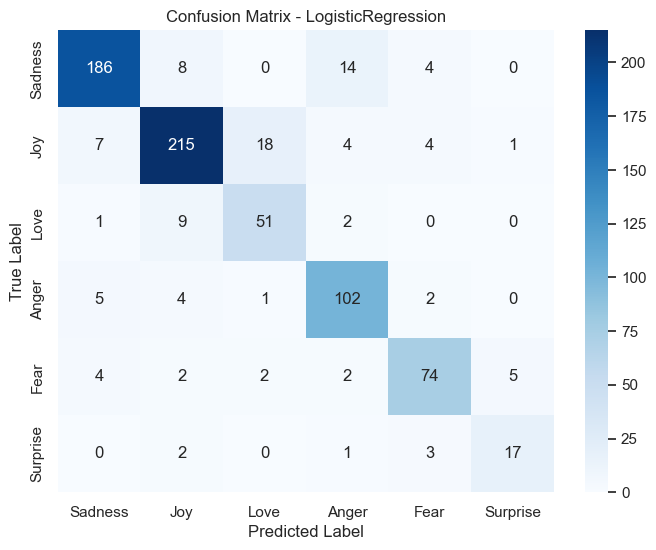


 Generating SHAP (RandomForest)...
 SHAP skipped: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. Consider retrying with the feature_perturbation='interventional' option. This check failed because for one of the samples the sum of the SHAP values was 650957122609984576200303364198988241523502535052721819655360896155749583151970934044408408435291131385028310500875597963873134575616.000000, while the model output was 0.040000. If this difference is acceptable you can set check_additivity=False to disable this check.

✅ Phase 1 Completed successfully.


In [5]:
# --- 0. IMPORTS & PARAMETERS ---
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Configuration
DEBUG = True          
MAX_ROWS = 5000
N_ESTIMATORS = 50 if DEBUG else 100
SHAP_SAMPLE = 100     

# Création des dossiers
os.makedirs("splits", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("figures", exist_ok=True)

# Mapping pour l'affichage (Important pour la fin)
label_map = {
    0: 'Sadness', 1: 'Joy', 2: 'Love', 
    3: 'Anger', 4: 'Fear', 5: 'Surprise'
}

# --- 1. CHARGEMENT ---
print(" Loading Data...")
df = pd.read_csv("emotions_cleaned_features.csv").dropna(subset=['text', 'label'])

if DEBUG and len(df) > MAX_ROWS:
    df = df.sample(n=MAX_ROWS, random_state=42).reset_index(drop=True)
    print(f" DEBUG MODE: Reduced to {MAX_ROWS} rows.")

# --- 2. SPLIT RIGOUREUX (70/15/15) ---
X = df['text']
# CORRECTION ICI : On utilise les CHIFFRES (0,1,2...) pas le texte
y = df['label'] 

print(" Splitting Data (70% Train / 15% Val / 15% Test)...")
X_train_raw, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val_raw, X_test_raw, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Sauvegarde
pd.DataFrame({'text': X_train_raw, 'label': y_train}).to_csv("splits/train.csv", index=False)
pd.DataFrame({'text': X_val_raw, 'label': y_val}).to_csv("splits/val.csv", index=False)
pd.DataFrame({'text': X_test_raw, 'label': y_test}).to_csv("splits/test.csv", index=False)
print("✅ Splits saved (using numeric labels).")

# --- 3. PREPROCESSING (TF-IDF) ---
print("Variable Transformation (TF-IDF)...")
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))

X_train_vec = vectorizer.fit_transform(X_train_raw)
X_val_vec = vectorizer.transform(X_val_raw)
X_test_vec = vectorizer.transform(X_test_raw)

joblib.dump(vectorizer, "models/tfidf_vectorizer.pkl")

# --- 4. MULTI-MODEL TRAINING (Le Tournoi) ---
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=N_ESTIMATORS, class_weight='balanced', random_state=42, n_jobs=-1),
    # Le MLP devrait maintenant fonctionner car y_train contient des entiers
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=10, random_state=42, early_stopping=True)
}

metrics = {}

print("\n Starting Model Tournament...")

for name, model in models.items():
    print(f"\n==> Training {name}...")
    start_time = time.time()
    
    model.fit(X_train_vec, y_train)
    
    y_pred_val = model.predict(X_val_vec)
    y_pred_test = model.predict(X_test_vec)
    
    duration = time.time() - start_time
    
    metrics[name] = {
        "Val Accuracy": accuracy_score(y_val, y_pred_val),
        "Val F1-Score": f1_score(y_val, y_pred_val, average='weighted'),
        "Test F1-Score": f1_score(y_test, y_pred_test, average='weighted'),
        "Training Time (s)": round(duration, 2)
    }
    joblib.dump(model, f"models/{name.replace(' ', '_')}.pkl")

# --- 5. RÉSULTATS ---
metrics_df = pd.DataFrame(metrics).T
print("\n --- TOURNAMENT RESULTS --- ")
print(metrics_df.sort_values(by="Val F1-Score", ascending=False))

# --- 6. ZOOM SUR LE VAINQUEUR (Matrice avec Noms) ---
best_model_name = metrics_df["Val F1-Score"].idxmax()
print(f"\n Champion: {best_model_name}")
best_model = models[best_model_name]

y_pred_final = best_model.predict(X_test_vec)
cm = confusion_matrix(y_test, y_pred_final)

# On traduit les chiffres (0,1...) en noms (Sadness, Joy...) pour le graphique
target_names = [label_map[i] for i in sorted(label_map.keys())]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig(f"figures/confusion_matrix_champion.png")
plt.show()

# --- 7. SHAP (Si possible) ---
try:
    print("\n Generating SHAP (RandomForest)...")
    rf_model = models["RandomForest"]
    explainer = shap.TreeExplainer(rf_model)
    X_val_sample = X_val_vec[:SHAP_SAMPLE].toarray()
    shap_values = explainer.shap_values(X_val_sample)
    
    plt.figure()
    # Correction patch pour SHAP multi-class
    vals = shap_values[1] if isinstance(shap_values, list) else shap_values
    shap.summary_plot(vals, X_val_sample, feature_names=vectorizer.get_feature_names_out(), show=False)
    plt.title("SHAP Summary Plot (Feature Importance)")
    plt.tight_layout()
    plt.savefig("figures/shap_summary.png")
    plt.show()
except Exception as e:
    print(f" SHAP skipped: {e}")

print("\n✅ Phase 1 Completed successfully.")